# Exploring the pareto front for OCC model and threshold selection

The idea:

In one-class classification we only have positive and unlabeled data for model selection. 

It is reasonable to assume that for a given true positive rate (which we can estimate from the training data) a model is the better the fewer positive predictions it returns for the unlabeled data.

It may help in a OCC application to explore the pareto front over all models and thresholds for the two conflicting goals of a high true positive rate and a low probabilty of positive predictions.

Let's get some toy data and try... 

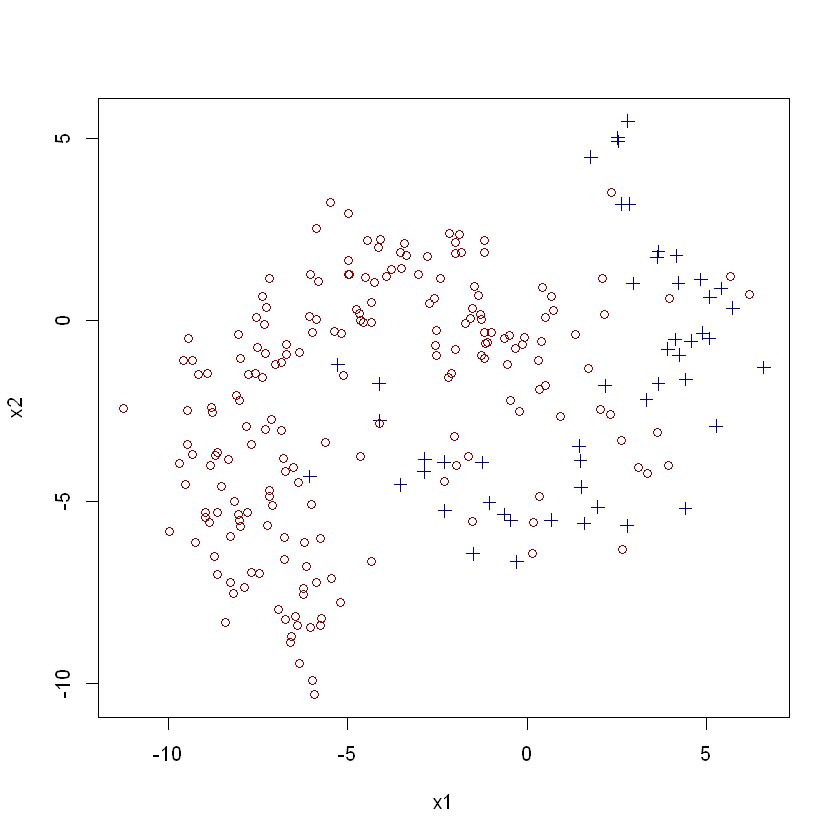

In [3]:
require(oneClass)
require(rPref)
require(dplyr)
require(doParallel)
registerDoParallel(cores=4)

data(bananas)
trs <- bananas_trainset(nP=50, nU=200)
plot(trs[, -1], pch=c(1, 3)[as.numeric(trs$y)],
     col=c("darkred", "darkblue")[as.numeric(trs$y)])

Lets get some cross-validated decision values for a couple of biased SVM models.

In [4]:
fit <- trainOcc(x=trs[, -1], y=trs$y)

Aggregating results
Selecting tuning parameters
Fitting sigma = 0.1, cNeg = 2048, cMultiplier = 4 on full training set


The cross validated decision values (distances in the case of the BSVM) for all models are stored here:

In [5]:
head(fit$pred)

,pred,obs,un,pos,rowIndex,sigma,cNeg,cMultiplier,Resample
1,un,pos,-0.01298373,-0.01298373,5,0.1,0.0009765625,4,Fold01
2,pos,pos,0.04663268,0.04663268,12,0.1,0.0009765625,4,Fold01
3,un,pos,-0.031213,-0.031213,15,0.1,0.0009765625,4,Fold01
4,pos,pos,0.04796925,0.04796925,22,0.1,0.0009765625,4,Fold01
5,pos,pos,0.02478882,0.02478882,40,0.1,0.0009765625,4,Fold01
6,un,un,-0.03860248,-0.03860248,54,0.1,0.0009765625,4,Fold01


The results based on which we usually do model selection are stored here:

In [6]:
head(fit$results)

,sigma,cNeg,cMultiplier,tpr,puP,ppp,puAuc,puF,puF1,pn,tprSD,puPSD,pppSD,puAucSD,puFSD,puF1SD,pnSD
1,0.1,0.0009765625,4,0.8,0.4389538,0.38,0.855,1.852749,0.5638564,1,0.1632993,0.1446978,0.06036923,0.1066927,0.9385884,0.1577803,0
2,0.1,0.0009765625,16,1,0.2,1,0.871,1,0.3333333,0,0,0,0,0.0735527,0,0,0
3,0.1,0.0009765625,64,1,0.2,1,0.803,1,0.3333333,0,0,0,0,0.1138274,0,0,0
4,0.1,0.0009765625,256,1,0.2,1,0.765,1,0.3333333,0,0,0,0,0.09407444,0,0,0
5,0.1,0.0009765625,1024,1,0.2,1,0.765,1,0.3333333,0,0,0,0,0.09407444,0,0,0
6,0.1,0.0009765625,4096,1,0.2,1,0.765,1,0.3333333,0,0,0,0,0.09407444,0,0,0


But the performance metrics, e.g. puF, are only evaluated at the separating hyperplane, i.e. at 0.
We might want to consider other threshold and calclate the true positive rate (tpr) and the probability of positive predictions (ppp) over all models and a lot of thresholds (by default 50 in the range of the returned decision values):

In [7]:
params <- fit$modelInfo$parameters$parameter
idx <- group_indices_(
  fit$pred, 
  .dots=as.character(params))
u_idx <- sort(unique(idx))

We want to keep the model position according to the `fit` and can do it like this:

In [8]:
res <- foreach(i = u_idx, .packages="oneClass") %dopar% {
    df <- fit$pred[idx==i, ]
    modrow = modelPosition(fit, modParam=df[1, as.character(params)])$row
    cbind(modrow=modrow, puSummaryThLoop(df, returnAll=TRUE))
}
res <- do.call(rbind, res)
head(res)

,modrow,th,tpr,puP,ppp,puF,puF1,pn
1,1,-0.03979214,1,0.2380952,0.84,1.190476,0.3846154,1
2,1,-0.03808773,1,0.2512563,0.796,1.256281,0.4016064,1
3,1,-0.03638332,1,0.2617801,0.764,1.308901,0.4149378,1
4,1,-0.03467891,1,0.2762431,0.724,1.381215,0.4329004,1
5,1,-0.03297449,1,0.2824859,0.708,1.412429,0.4405286,1
6,1,-0.03127008,1,0.2873563,0.696,1.436782,0.4464286,1


Now we do not only have the metrics at one but 50 thresholds per model. 
Which makes 12600 possible model / threshold candidates.

In [9]:
nrow(res)

[1] 12600

How should we select a solution knowing that we should use puF and similar metrics with caution?
First we can see if we can reduce the number of solutions by using the non-dominated solutions, i.e. the solutions on the pareto-front. 
These turn out to be less: 

In [10]:
nondominated <- psel(res, high(tpr) * low(ppp)) 
# There are lots of duplicates with equal tpr and ppp values which we remove
nrow(nondominated)
nondominated <- nondominated[!duplicated(nondominated[, c("tpr", "ppp")]), ]
nrow(nondominated)
nondominated <- nondominated[order(-nondominated$tpr, nondominated$ppp), ]
nondominated # now ordered by descending tpr

[1] 423

[1] 33

,modrow,th,tpr,puP,ppp,puF,puF1,pn
2127,43,-0.836852,1,0.5376344,0.372,2.688172,0.6993007,1
2541,51,0.1598756,0.98,0.6363636,0.308,3.118182,0.7716535,1
2841,57,-0.04463303,0.96,0.6575342,0.292,3.156164,0.7804878,1
2892,58,0.2744539,0.94,0.6714286,0.28,3.155714,0.7833333,1
3884,78,0.3549801,0.92,0.6764706,0.272,3.111765,0.779661,1
3886,78,0.4391917,0.9,0.6923077,0.26,3.115385,0.7826087,1
2140,43,0.6315571,0.88,0.6984127,0.252,3.073016,0.7787611,1
2141,43,0.7445116,0.86,0.7166667,0.24,3.081667,0.7818182,1
2142,43,0.8574662,0.84,0.7241379,0.232,3.041379,0.7777778,1
4942,99,0.7765695,0.8,0.7272727,0.22,2.909091,0.7619048,1


And we only have a low fraction of models in which the nondominated solutions live in.

In [11]:
nondominated_models <- nondominated$modrow
nrow(fit$results)
length(unique(nondominated$modrow))

[1] 252

[1] 21

The following plot shows all solutions (no color), the solutions at the pareto front (blue), and the solutions at the threshold = 0:

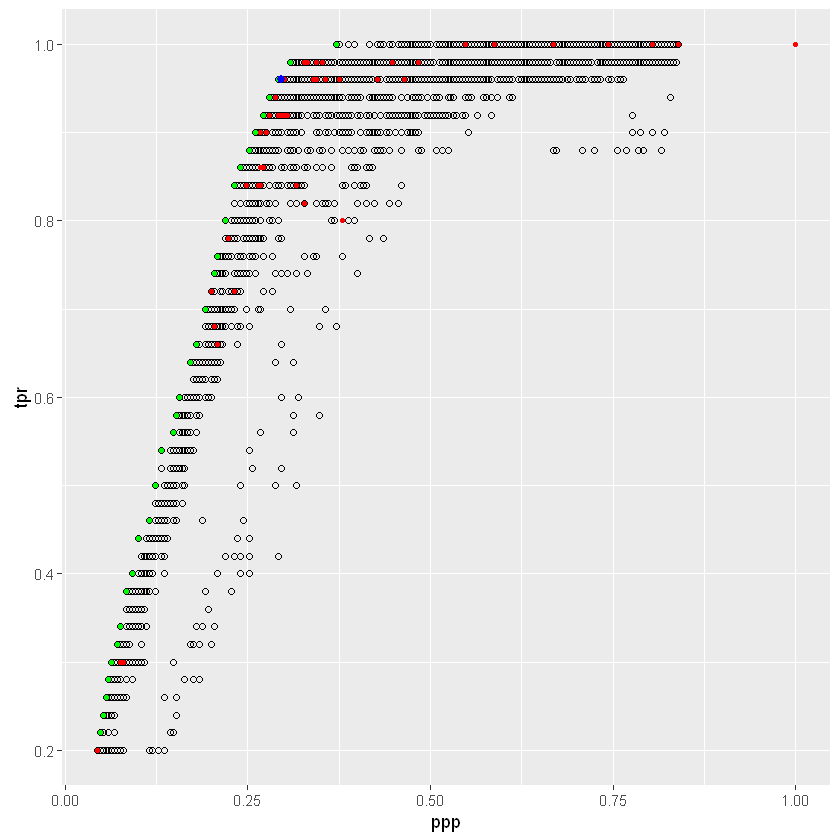

In [12]:
ggplot(res, aes(x = ppp, y = tpr)) + 
  geom_point(shape = 21) + 
  geom_point(data=nondominated, size = 1, col="green") +
  geom_point(data=fit$results, size = 1, col="red") + 
  geom_point(data=fit$results[modelPosition(fit)$row, , drop=F], size = 2, col="blue")

And how is that useful?

* Automatic model selection with whatever PU-based optimization might benefit by considering only the non-dominated solutions since this might reduce the risk.

* If we manually analyze different models, e.g. by plotting the histograms, it reduces the models to be investivated to a reasonable size.

Below are the histogram plots of all models with with the thresholds of the non-dominant solutions. But first the one of the (so-far) selected model:

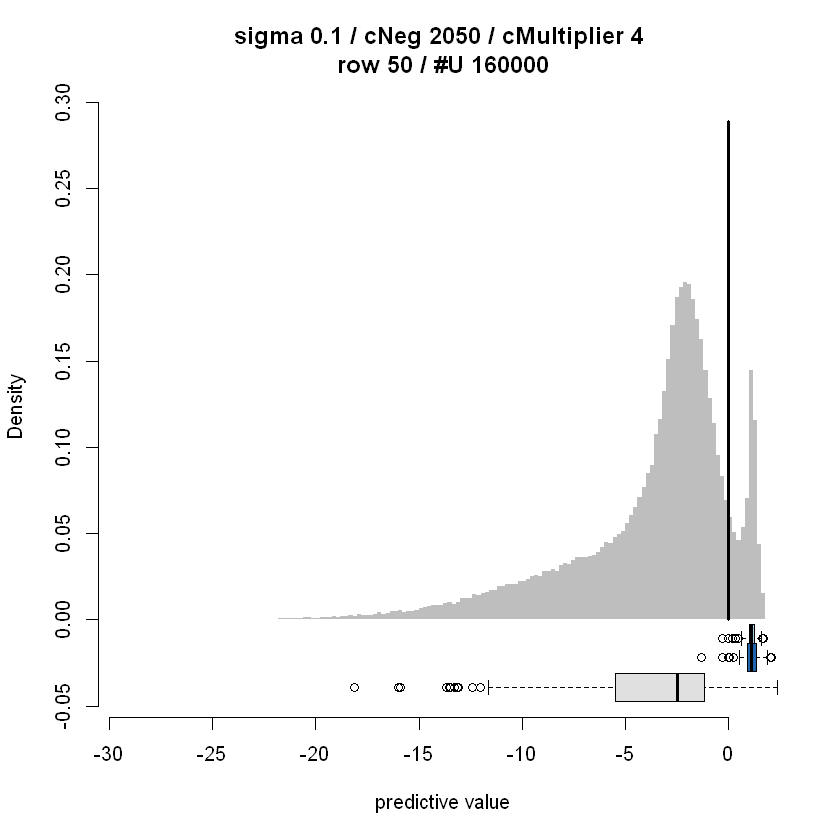

In [31]:
hist(fit, predict(fit, bananas$x[]), th=0)

Is this model one  of the models with nondominated solutions? 

In [33]:
unique(nondominated$modrow)
modelPosition(fit)$row  %in% unique(nondominated$modrow)

[1]  43  51  57  58  78  99 141 127  29  38  37 107  36  30 113  45  44 190 198
[20] 191  64

[1] FALSE

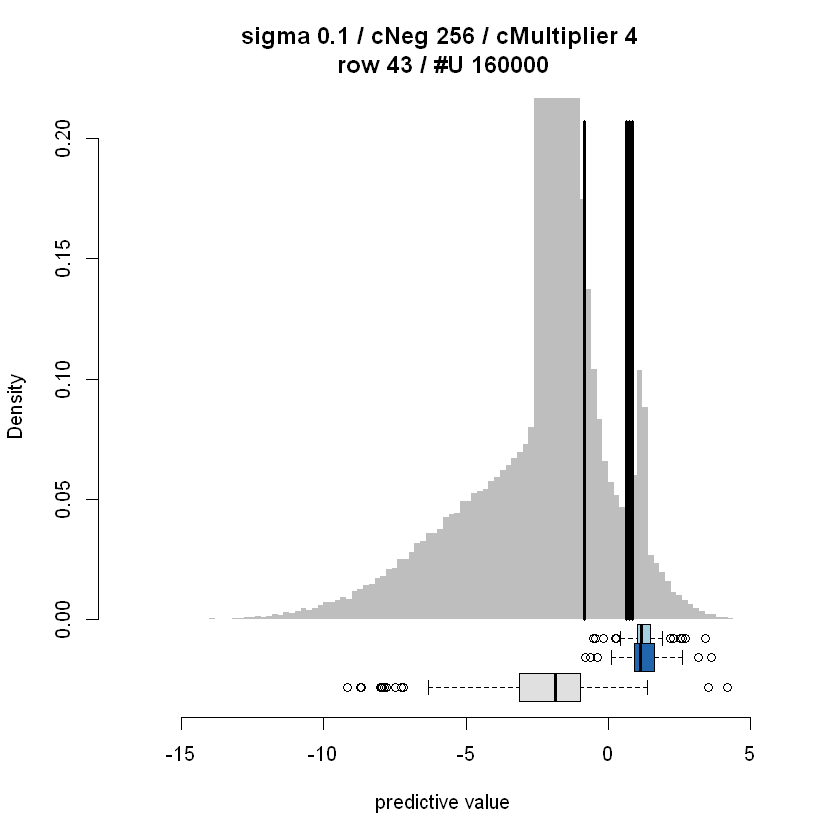

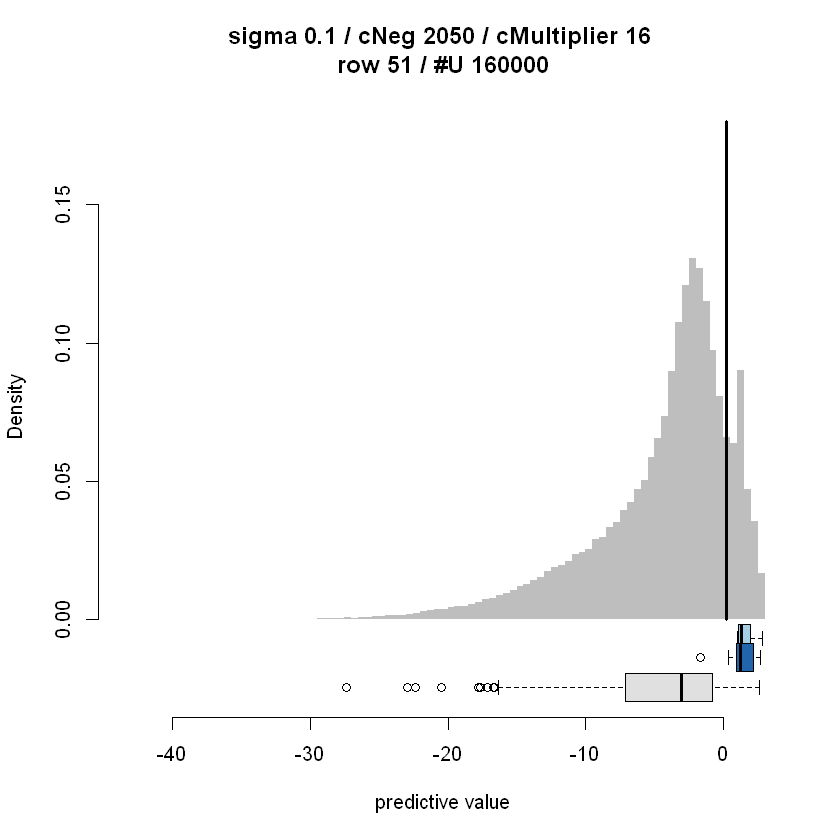

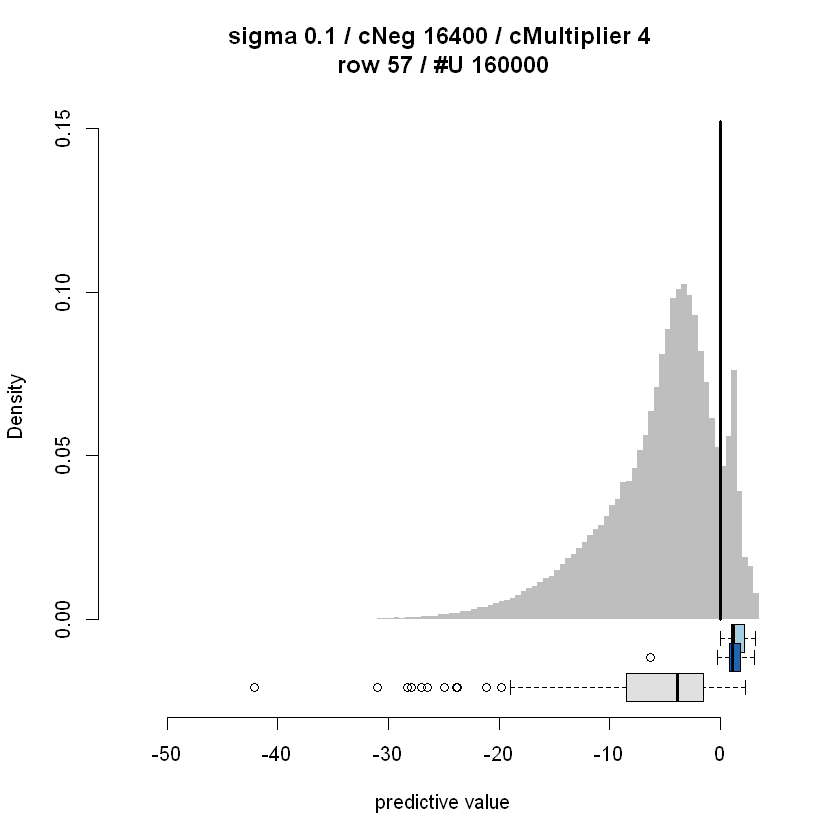

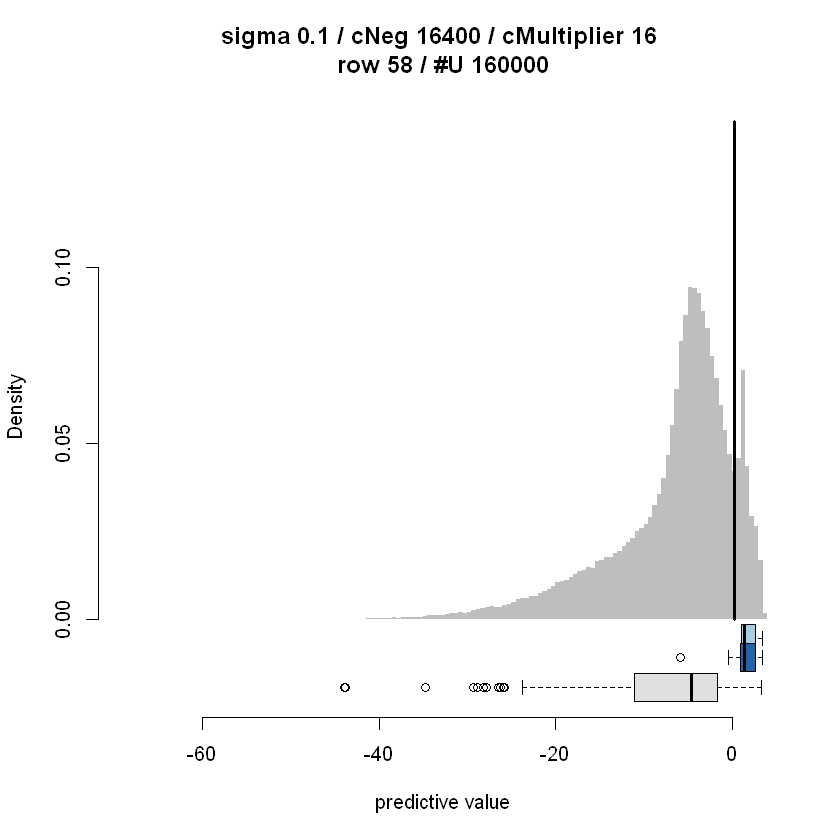

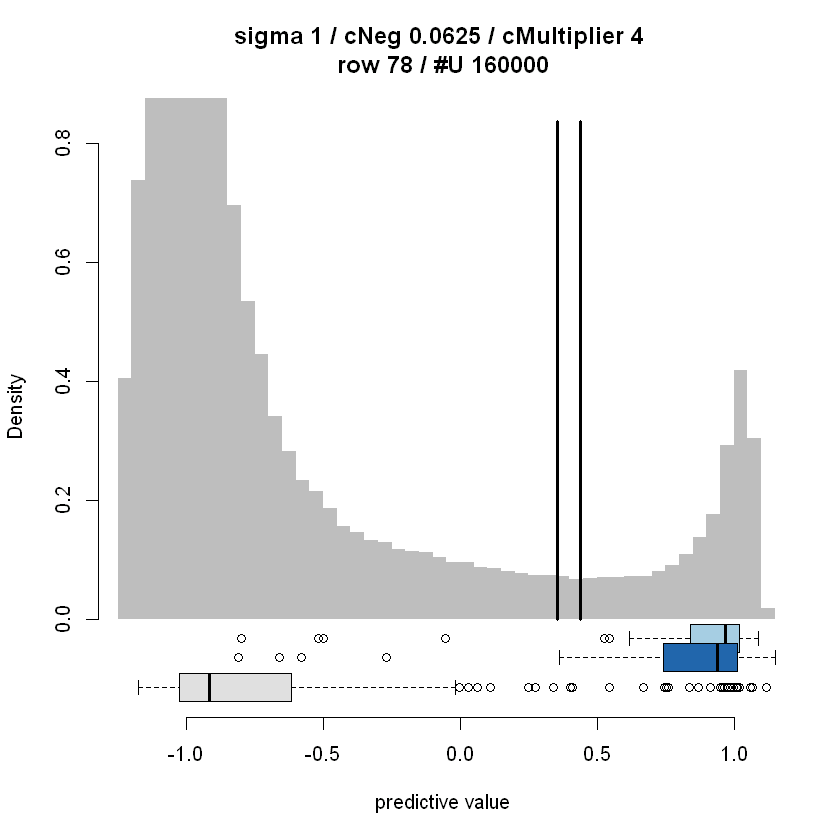

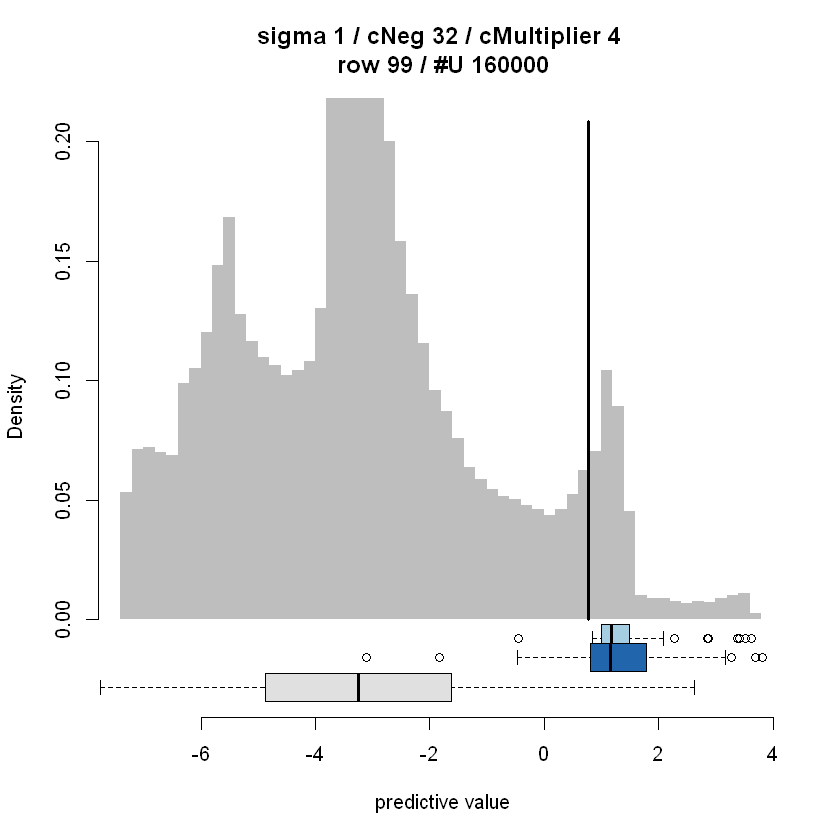

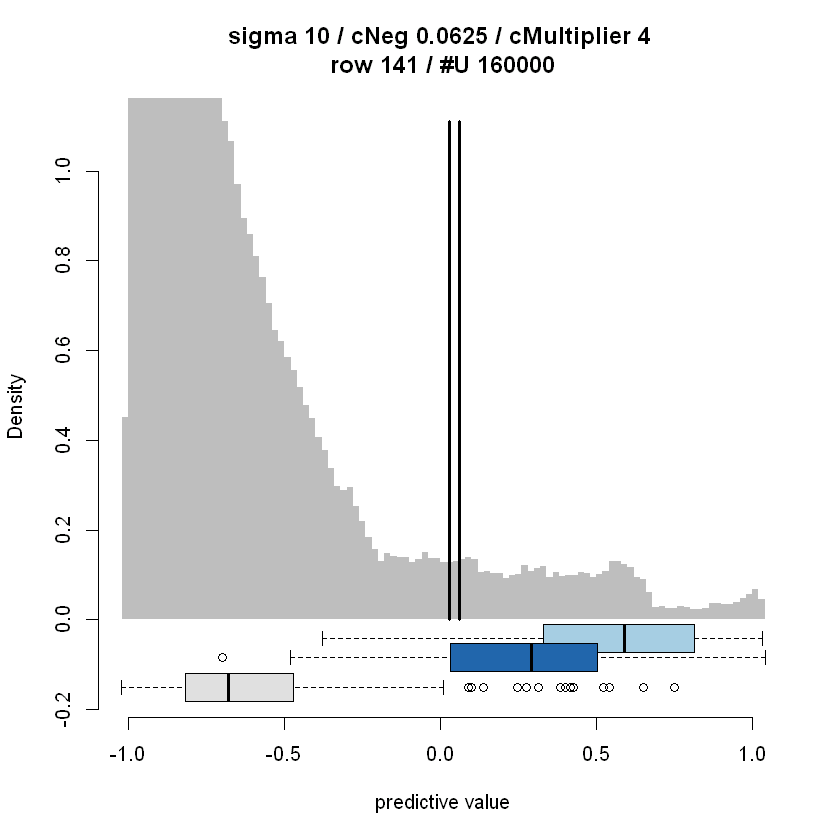

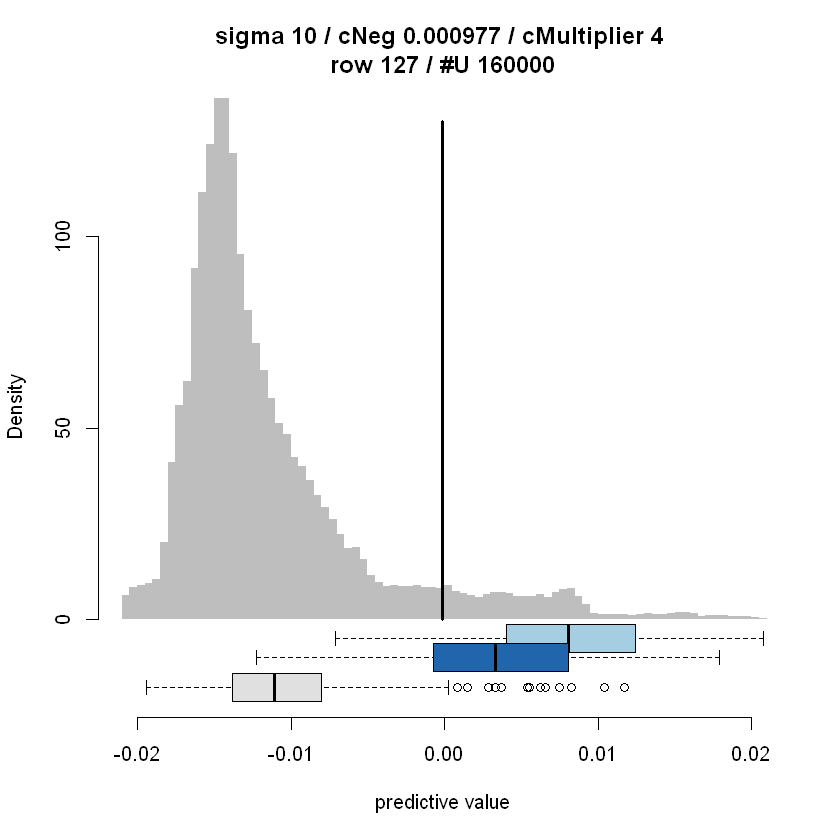

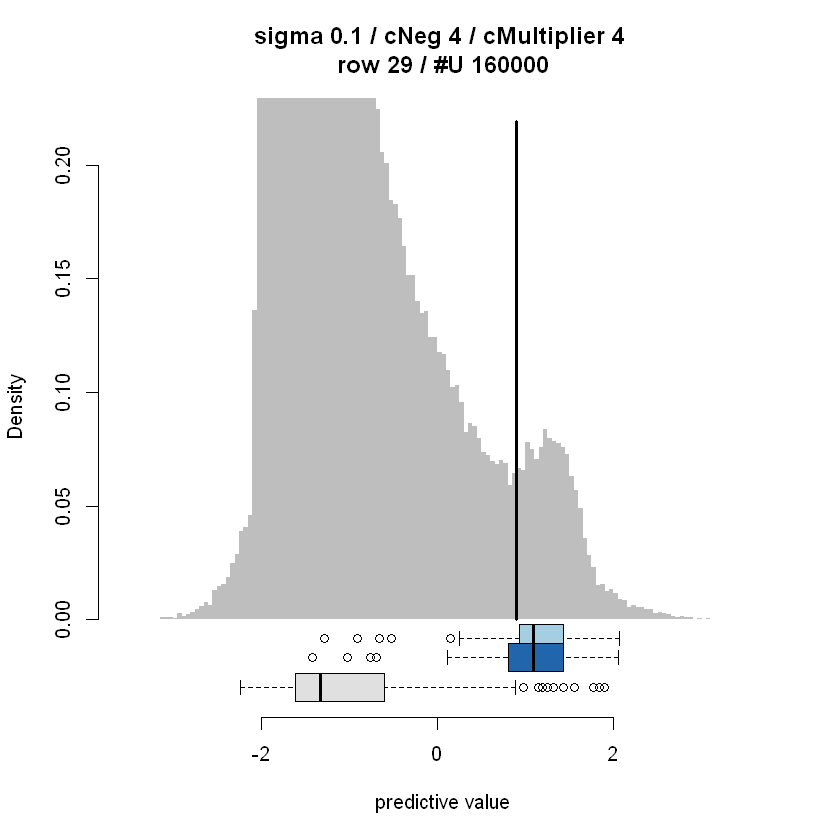

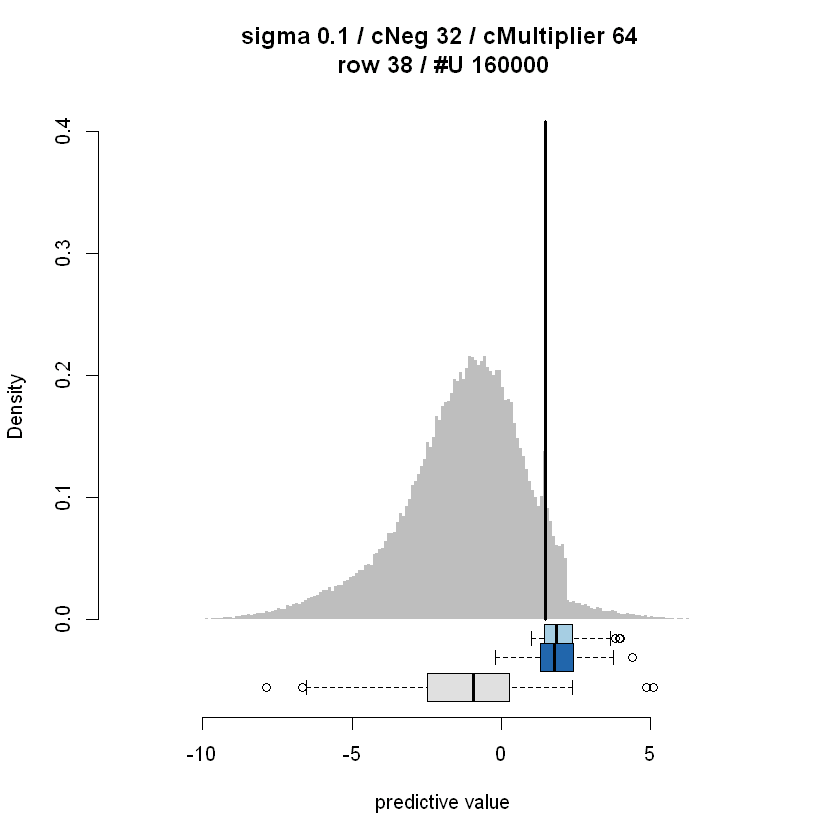

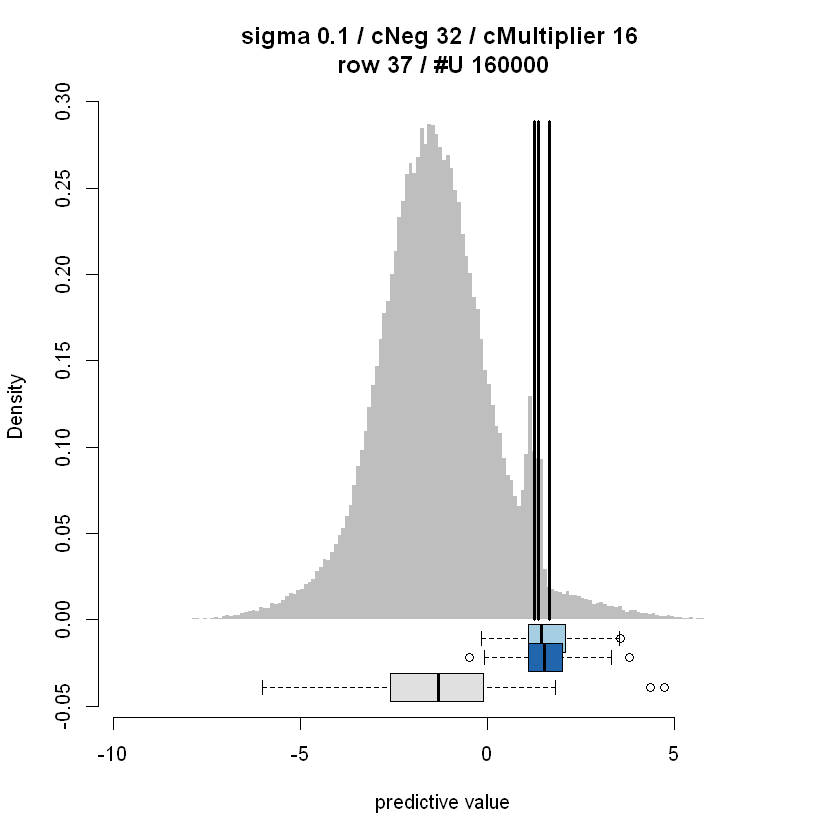

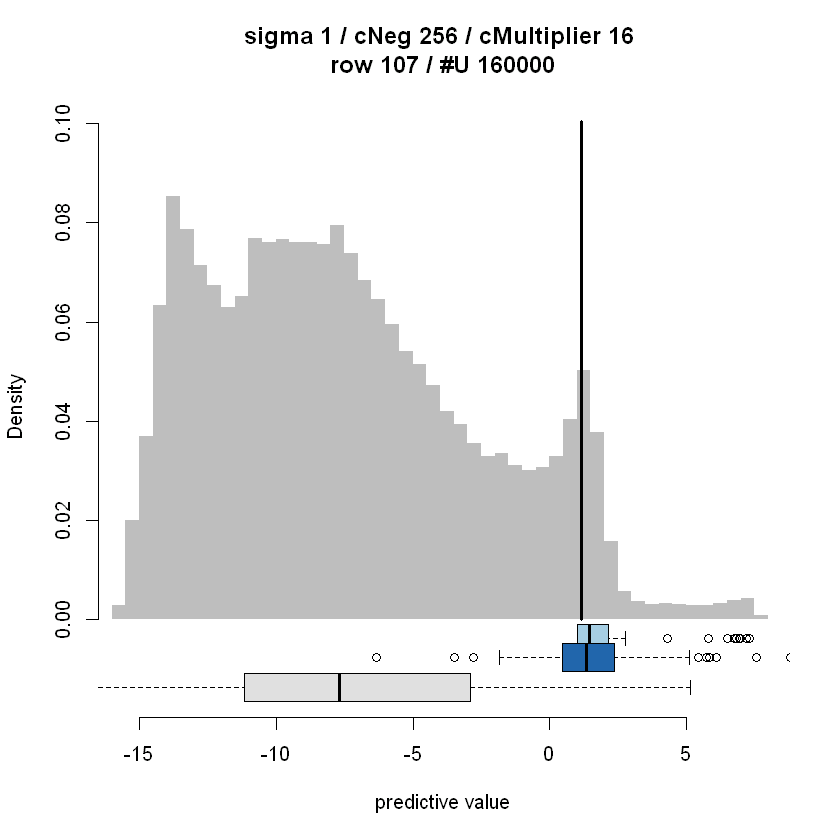

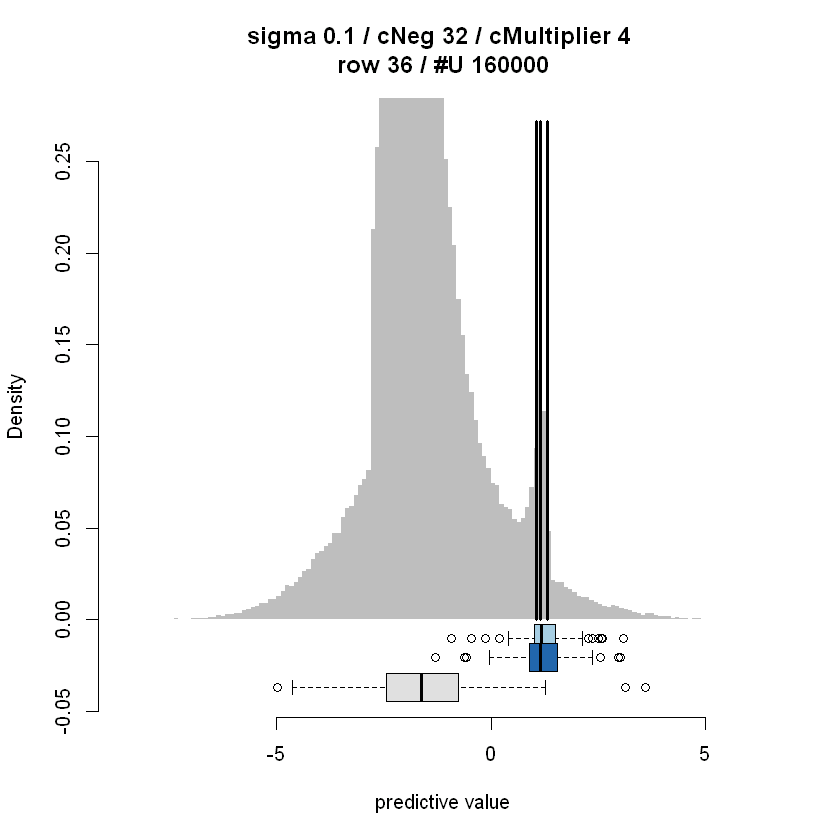

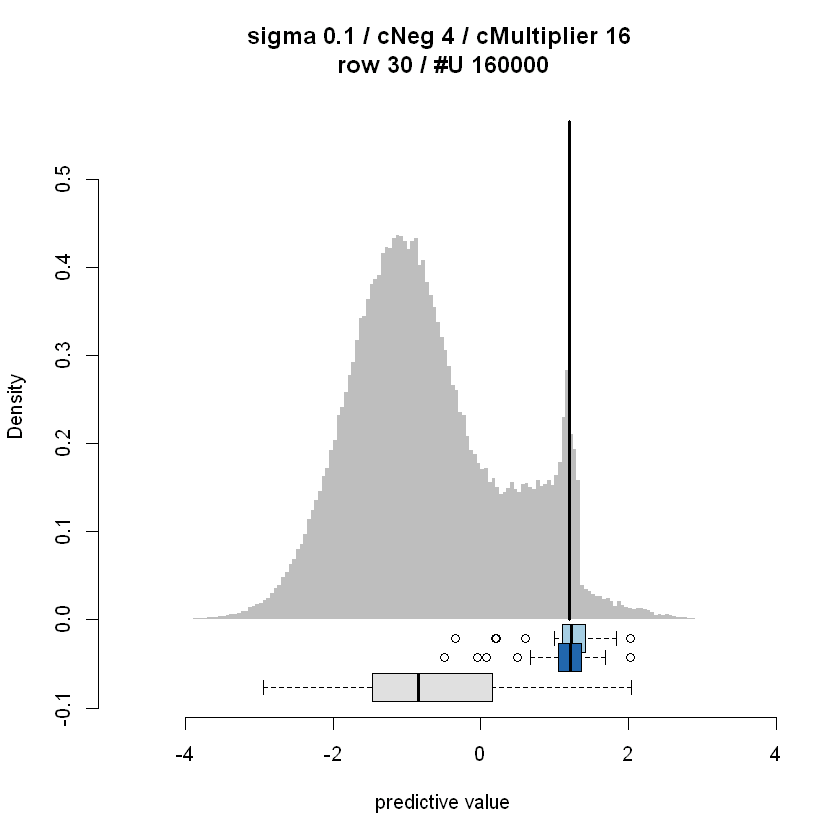

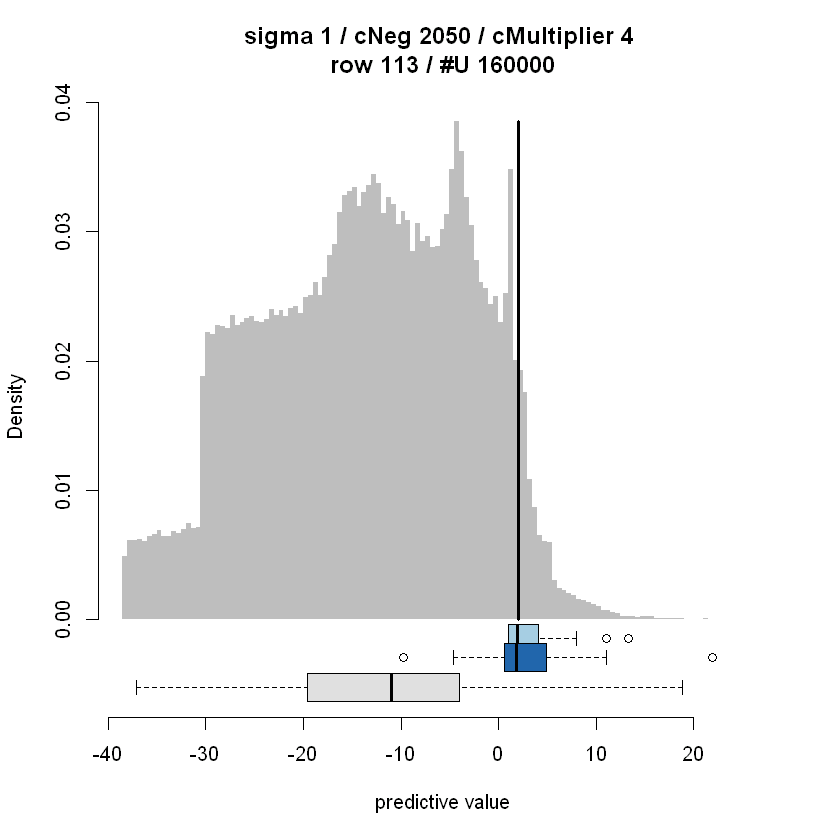

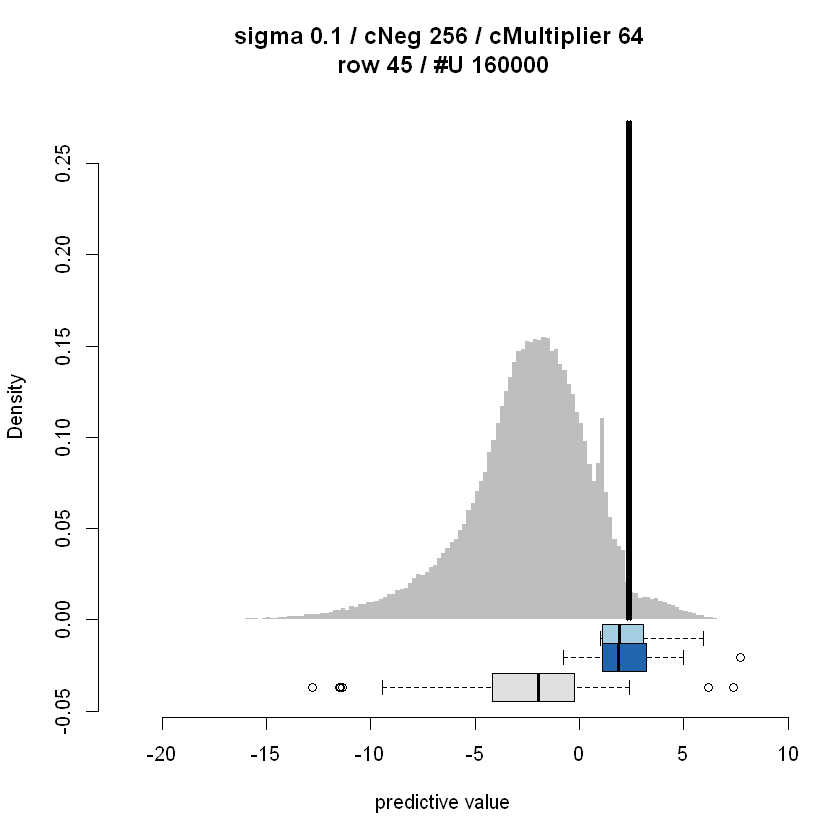

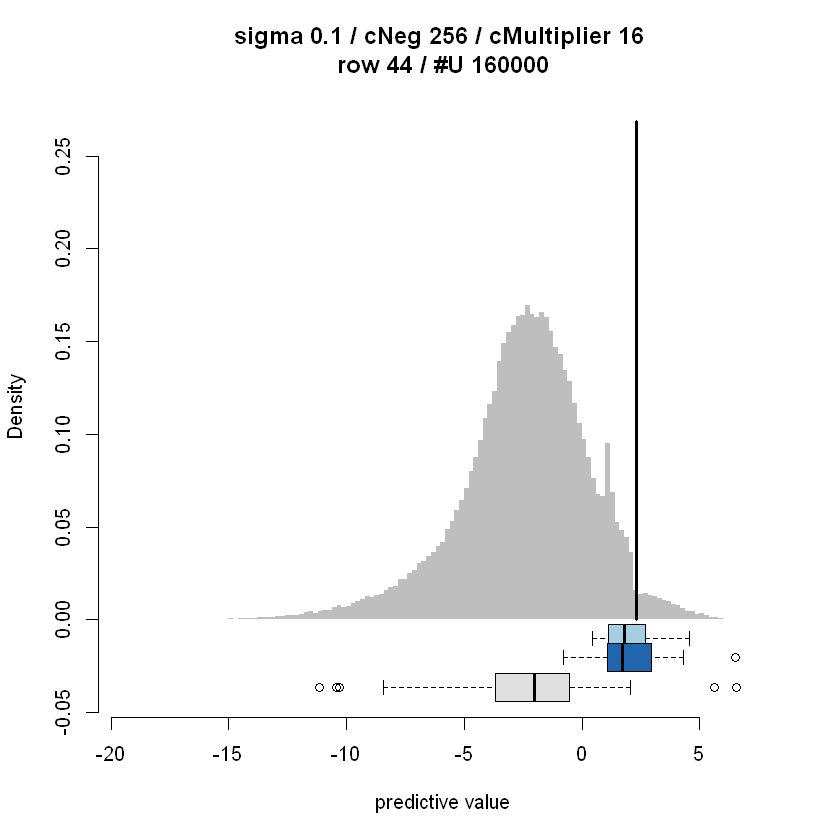

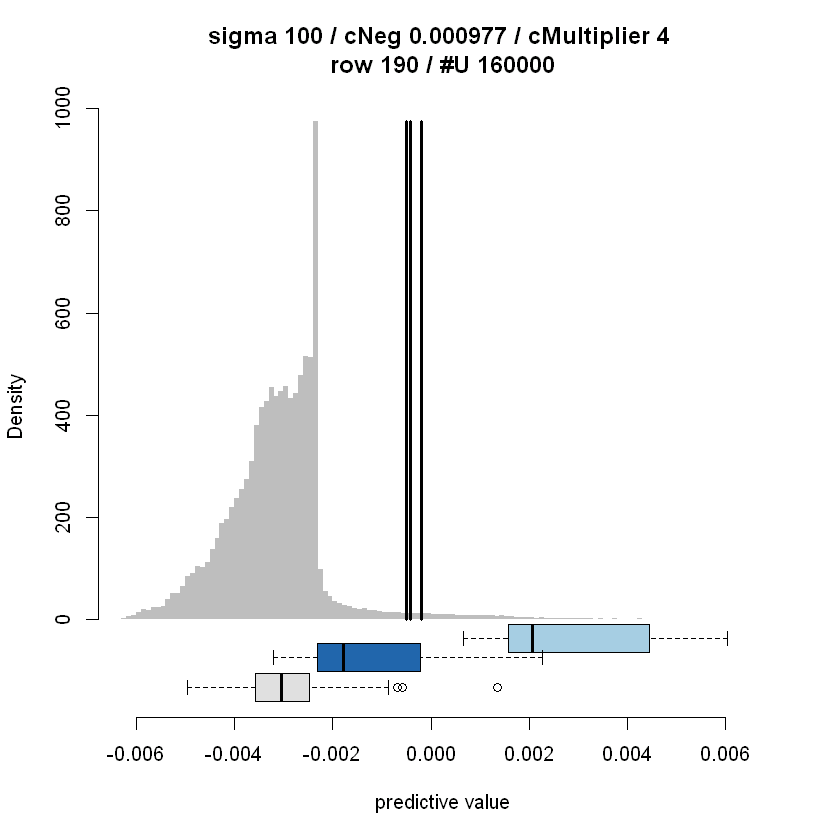

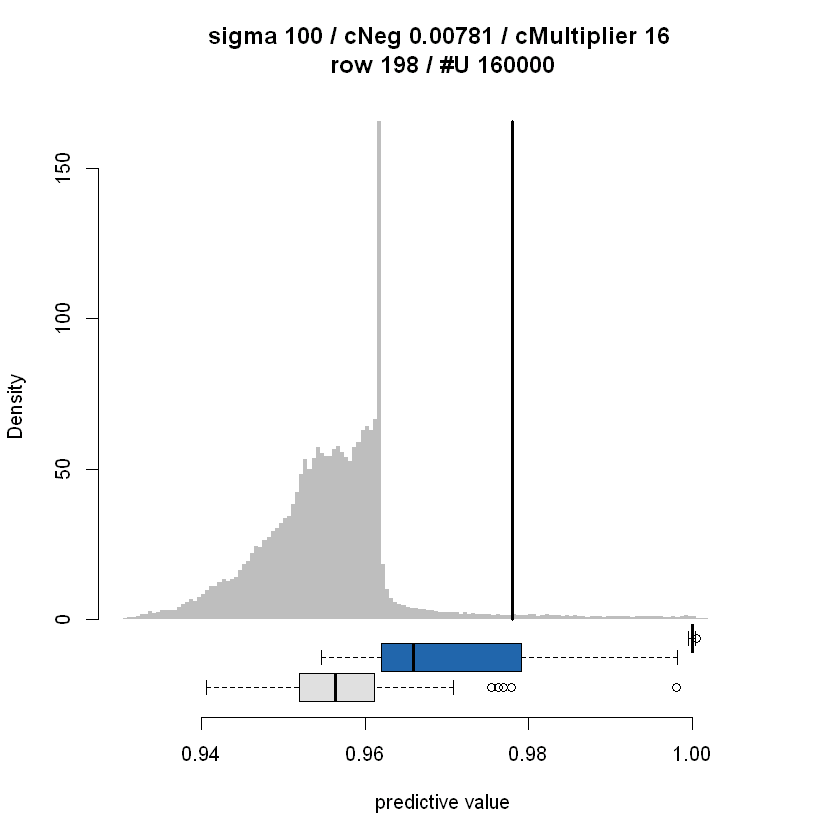

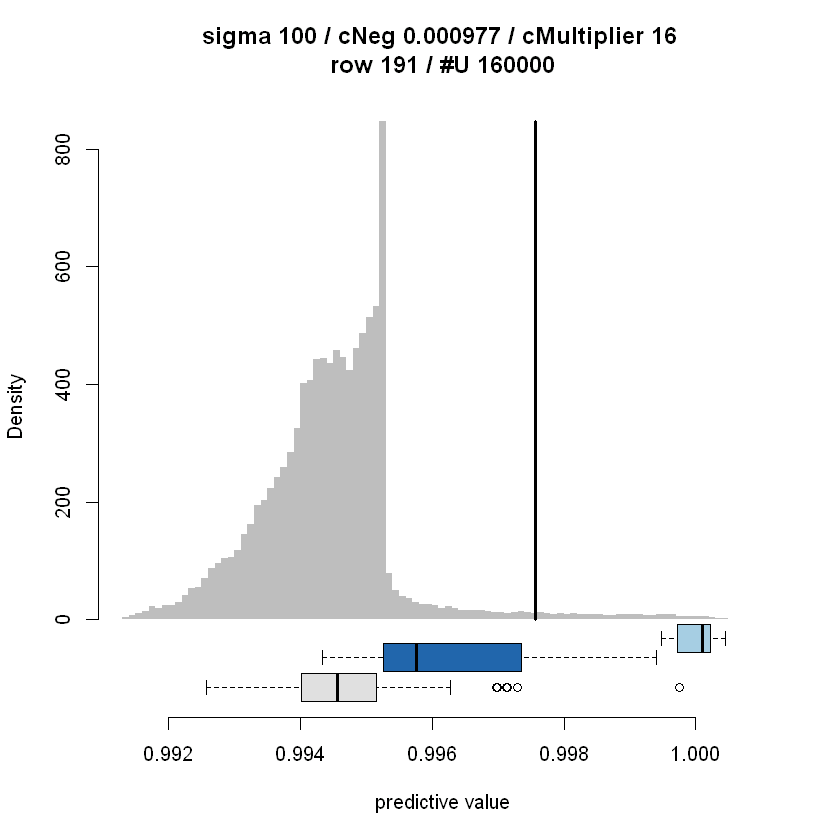

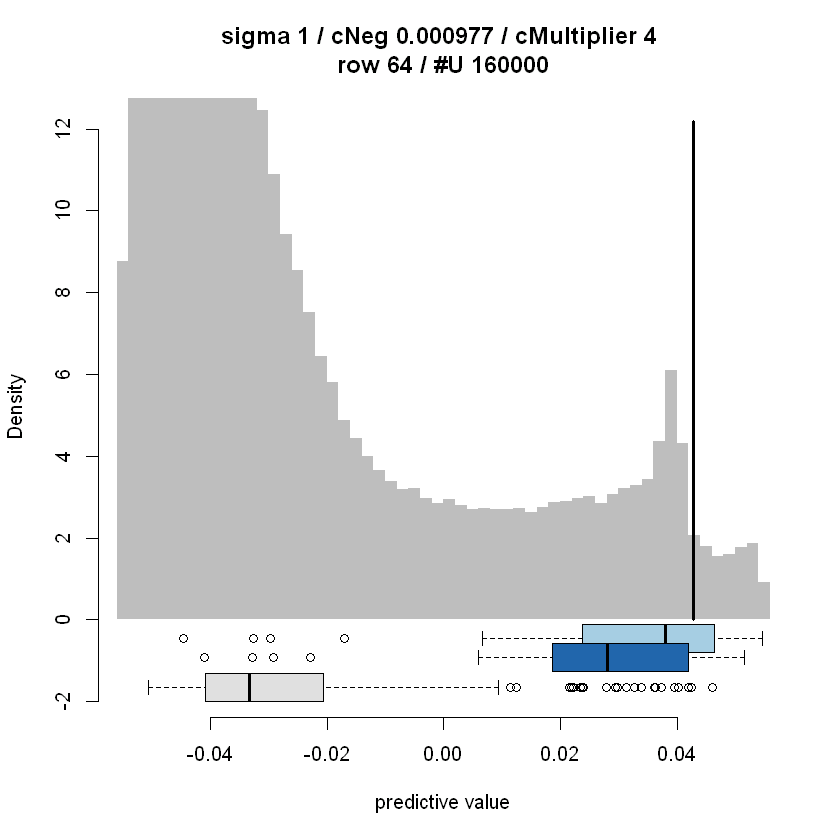

In [25]:
for (mr in unique(nondominated$modrow)) {
    fit <- update(fit, modRow = mr)
    hist(fit, predict(fit, bananas$x[]), th=nondominated$th[nondominated$modrow==mr])
}

[1] 155

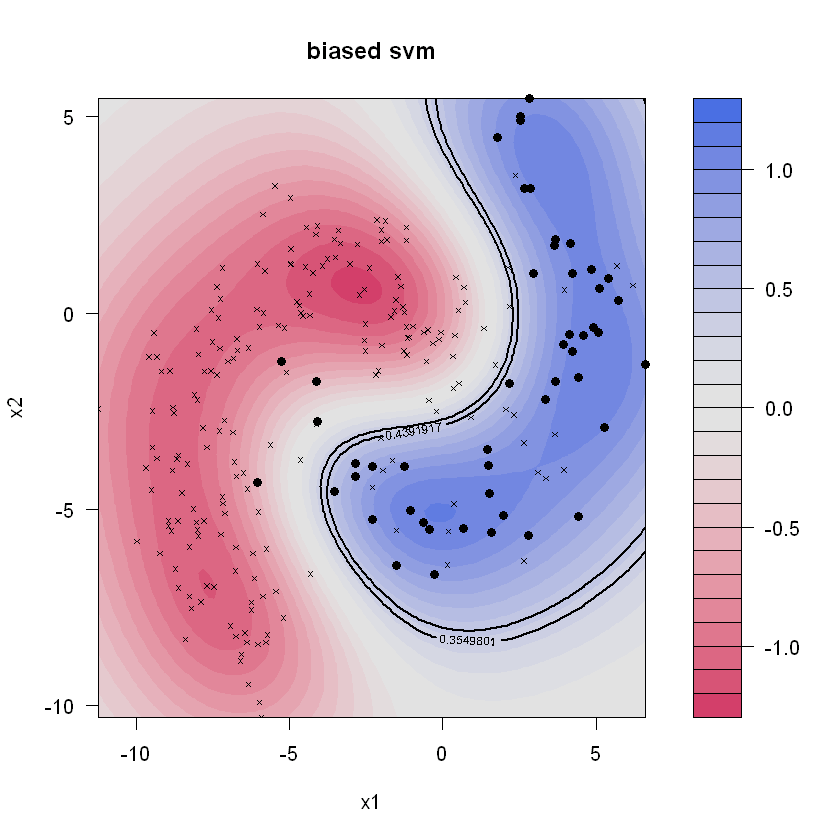

In [36]:
fit <- update(fit, modRow=78)
fit$finalModel@nSV
featurespace(fit, th=nondominated$th[nondominated$modrow==78])